# Stock Price Indicator
                
## Project aims to predict adjusted close price of some stocks chosen previously.


## 1- Data Exploration
### A- get historical values
### B- plot Adjusted Close column
### C- check for null values


In [1]:
#A- get historical values

import pandas as pd
import pandas_datareader as pdr
import datetime

stock_list = ['AAPL', 'AMZN', 'AVGO', 'CSCO', 'MA', 'MSFT', 'NVDA', 'NVS', 'PFE', 'QCOM', 'TXN', 'V', 'WMT']

start=datetime.datetime(2010,3,20)

end=datetime.datetime(2019,3,19)

#for stock in stock_list:
    #history = pdr.get_data_yahoo(stock, start, end)
    #history.to_csv('./data1/'+stock+'.csv')

AMZN = pd.read_csv('data/AMZN.csv', header=0, parse_dates=['Date'])
AMZN.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-03-22,130.960007,128.639999,130.199997,130.470001,5383400,130.470001
1,2010-03-23,130.940002,128.070007,130.889999,129.259995,4213100,129.259995
2,2010-03-24,129.399994,127.199997,128.639999,128.039993,4696400,128.039993
3,2010-03-25,136.910004,128.039993,129.139999,134.729996,16209600,134.729996
4,2010-03-26,136.990005,133.759995,134.899994,135.059998,6565700,135.059998


In [2]:
# B- plot Adjusted Close column

import datetime
import matplotlib as plt

stock_data_list = []

for stock in stock_list:
    stock_data = pd.read_csv('data/'+stock+'.csv', header=0, parse_dates=['Date'])
    stock_data.set_index('Date',inplace=True)
    plott = stock_data['Adj Close'].plot(figsize=(16, 12), label=stock)
    plott.legend()
    stock_data['stock_name'] = stock
    stock_data_list.append(stock_data)



In [3]:
# C- check for null values

for stock_data in stock_data_list:
    print(stock_data.isnull().any().any())

False
False
False
False
False
False
False
False
False
False
False
False
False


## 2- Domain Research
### A- Add Key Feature Columns to Data
### B- Plot Examples for Key Features

In [4]:
#A- Add Key Feature Columns to Data
import numpy as np
#Add MACD 26, 12 day periods
def add_MACD(dataframe):
    macd26 = dataframe['Adj Close'].ewm(span=26, min_periods=26, adjust= True).mean()
    macd12 = dataframe['Adj Close'].ewm(span=12, min_periods=12, adjust= True).mean()
    dataframe["MACD"] = macd26-macd12
    return dataframe

#Add RSI Wilder's RSI
def add_RSI(df, column='Adj Close', period=14):
    delta = df[column].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    rUp = up.ewm(com=period - 1,  adjust=False).mean()
    rDown = down.ewm(com=period - 1, adjust=False).mean().abs()

    rsi = 100 - 100 / (1 + rUp / rDown)    
    return df.join(rsi.to_frame('RSI'))

#Add Bollinger Bands
def add_BollingerBand(df, column='Adj Close', period=20):
    sma = df[column].rolling(window=period, min_periods=period - 1).mean()
    std = df[column].rolling(window=period, min_periods=period - 1).std()

    up = (sma + (std * 2)).to_frame('BBANDUP')
    lower = (sma - (std * 2)).to_frame('BBANDLO')
    return df.join(up).join(lower)

def get_weighted_average(dataframe,window,columnname_data,columnname_weights):
    processed_dataframe=dataframe.loc[:,(columnname_data,columnname_weights)].set_index(columnname_weights)   
    def get_mean_withweights(processed_dataframe_windowed):
        return np.average(a=processed_dataframe_windowed,weights=processed_dataframe_windowed.index)
    tmp_df = processed_dataframe.rolling(window=window).apply(func=get_mean_withweights,raw=False)
    tmp_df = tmp_df.reset_index()
    dataframe = dataframe.reset_index()
    tmp_df2 = dataframe.join(tmp_df['Adj Close'].to_frame('WMA'))
    tmp_df2.set_index('Date',inplace=True)
    #print(tmp_df2)
    return tmp_df2


for index, stock_data in enumerate(stock_data_list):
    stock_data = add_MACD(stock_data)
    stock_data = add_RSI(stock_data)
    stock_data = add_BollingerBand(stock_data)
    stock_data = get_weighted_average(stock_data,10,'Adj Close', 'Volume')
    #print(stock_data.columns)
    #print(stock_data)
    #stock_data['MACD'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['RSI'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['BBANDUP'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['BBANDLO'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    #stock_data['WMA'].plot(figsize=(16, 12), label=stock_data['stock_name'][0])
    stock_data = stock_data[25:] #delete NaN values
    stock_data_list[index] = stock_data

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'stock_name',
       'MACD', 'RSI', 'BBANDUP', 'BBANDLO', 'WMA'],
      dtype='object')


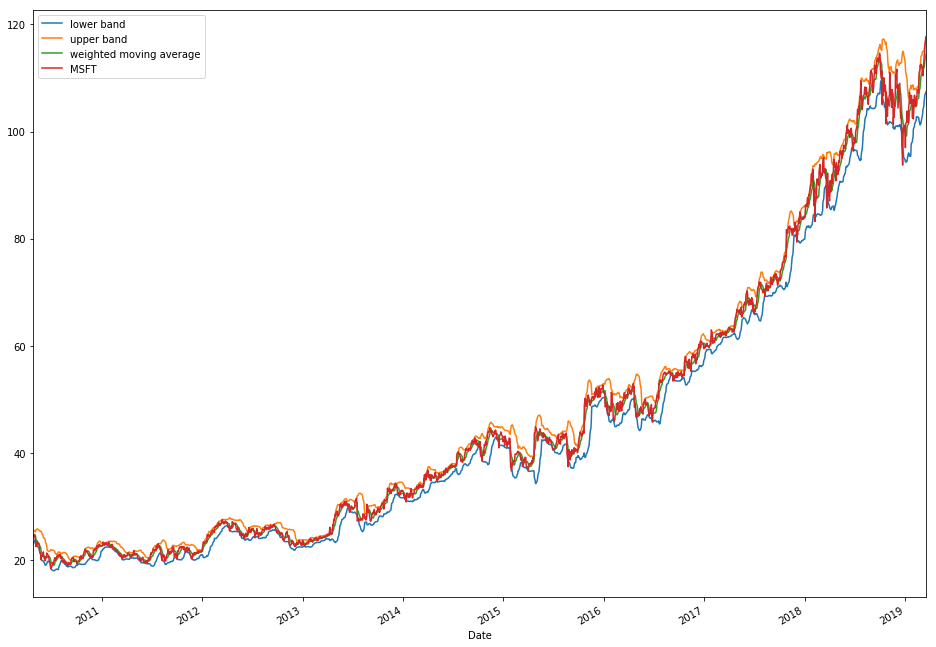

In [5]:
def plot_stock(index):
    stock_data = stock_data_list[index]
    print(stock_data.columns)

    #plot Bollinger Bands
    plt1 = stock_data['BBANDLO'].plot(figsize=(16, 12), label='lower band')
    stock_data['BBANDUP'].plot(label='upper band')
    stock_data['WMA'].plot(label='weighted moving average')
    stock_data['Adj Close'].plot(label=stock_data['stock_name'][0])
    plt1.legend()
    
plot_stock(5)



#plot RSI and MACD
#plot2 =  stock_data['RSI'].plot(figsize=(16, 12), label='RSI')

## 2- Data Normalization & Seperation

In [6]:
from sklearn import preprocessing

def normalize_data(n_stock_list):
    scaler = preprocessing.MinMaxScaler()
    normalized_stock_list = []
    y_adj_close_list = []
    for stock_data in n_stock_list:
        stock_data = stock_data.drop(columns='stock_name')

        names = stock_data.columns
        scaled_df = scaler.fit_transform(stock_data)
        scaled_df = pd.DataFrame(scaled_df, columns=names)
        #scale adjusted price to 100
        scaled_df['Adj Close'] = scaled_df['Adj Close'].apply(lambda x: x*100)


        y_adj_close_list.append(scaled_df['Adj Close'])
        scaled_df = scaled_df.drop(columns='Adj Close')

        normalized_stock_list.append(scaled_df)
    return normalized_stock_list, y_adj_close_list

#since we want n+1 adj close price to be predicted with the n th day values
#we need to shift y values for 1 day 
def shift_data_one_day(y_adj_close_list):
    for y_adj_close in y_adj_close_list:
        y_adj_close.shift(-1)




normalized_stock_list, y_adj_close_list = normalize_data(stock_data_list)
shift_data_one_day(y_adj_close_list)
    
print(y_adj_close_list[5]) # our target list to predict  
print(normalized_stock_list[5]) # our input values for models  
   


0         6.232732
1         6.281071
2         6.353582
3         5.982979
4         6.240790
5         5.652660
6         5.427072
7         4.726149
8         4.105787
9         4.693921
10        4.645576
11        5.096754
12        4.935621
13        4.685865
14        4.693921
15        4.523967
16        4.232612
17        3.318116
18        3.099600
19        2.638310
20        2.476448
21        1.618589
22        2.419793
23        2.257935
24        2.330771
25        2.792076
26        3.115788
27        2.249843
28        1.845195
29        1.699525
           ...    
2209     89.024115
2210     87.829382
2211     87.066355
2212     87.467954
2213     87.046286
2214     88.692802
2215     88.612478
2216     88.702841
2217     90.028084
2218     89.977883
2219     89.413259
2220     91.691931
2221     93.264816
2222     93.889933
2223     94.666298
2224     94.474726
2225     94.333570
2226     94.837701
2227     94.565474
2228     94.000842
2229     94.051258
2230     92.

/home/ai/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## 3- Building:
### A: Benchmark Model
### B: RMSE and R2 Validation
### C: Solution Model
### D: Test Flow


In [7]:
# A- For Benchmark we will use standard linear regression
from keras.layers import Dense
from keras.models import Model, Sequential
from keras import initializers, optimizers
from sklearn.model_selection import train_test_split

from pylab import *


def create_benchmark_model():
   model = Sequential()
   model.add(Dense(1, activation = 'linear', input_dim = 10))
   sgd = optimizers.SGD(lr=0.2)
   model.compile(optimizer = sgd, loss = 'mean_squared_error', metrics = ['accuracy'])
   return model

# B - RMSE Score, R2 Score
from sklearn.metrics import mean_squared_error, r2_score


def RMSE_score(y, y_predicted, method_name):
    RMSE_score = np.sqrt(mean_squared_error(y, y_predicted))
    print(method_name + " RMSE Score: {0}".format(RMSE_score))
    return RMSE_score


def R2_score(y, y_predicted, method_name):
    R2_score = r2_score(y, y_predicted)
    print( method_name +" R2 Score: {0}".format(R2_score))
    return R2_score

def check_score(y, y_predicted, method_name):
    rmse = RMSE_score(y, y_predicted, method_name)
    r2 = R2_score(y, y_predicted, method_name)
    return rmse, r2


Using TensorFlow backend.


In [8]:
# C - Solution Models LSTM and SVM 
from sklearn import svm
from keras.layers.recurrent import LSTM
from keras.layers import Dropout, Activation, Flatten
import numpy 

def create_svm_linear_model():
    model = svm.SVR(kernel='linear', C=100)
    return model

def create_svm_polynomial_model():
    model = svm.SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)
    return model

def create_lstm_model():
    model = Sequential()
    model.add(LSTM(return_sequences=True, input_shape=(1, 10), units=100, dropout=0.2))
    model.add(Flatten())
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mse', optimizer='rmsprop')
    return model

def create_svm_poly_with_parameters(_c = 100, _gamma ='auto', _epsilon=0.1, _degree=3, _coeff0=1):
    model = svm.SVR(kernel='poly', C=_c, gamma=_gamma, degree=_degree, epsilon=_epsilon, coef0=_coeff0)
    return model
       

In [9]:
#D -Test Flow

def drive_test(use_different_models):
    results_dataframe = pd.DataFrame()
    
    for index, normalized_stock in enumerate(normalized_stock_list):
        #below line is for only development stage to keep run time short
        #if(index > 3): break
        #create models
        if (use_different_models or index == 0):
            linear_regression_model = create_benchmark_model() 
            svm_linear = create_svm_linear_model()
            svm_polynomial = create_svm_polynomial_model()
            lstm_model = create_lstm_model()
        linear_regression_model = create_benchmark_model() 
        svm_linear = create_svm_linear_model()
        svm_polynomial = create_svm_polynomial_model()
        lstm_model = create_lstm_model()
        #split data
        X_train, X_test, y_train, y_test = train_test_split(normalized_stock_list[index], 
                                        y_adj_close_list[index], test_size=0.20, random_state=42)

        linear_regression_model.fit(X_train, y_train, epochs =100,batch_size = 32)
        linear_y_predict = linear_regression_model.predict(X_test)


        svm_linear.fit(X_train, y_train)
        svm_linear_y_predict = svm_linear.predict(X_test)


        svm_polynomial.fit(X_train, y_train)
        svm_polynomial_y_predict = svm_polynomial.predict(X_test)

        trainX = numpy.reshape(X_train.values, (X_train.shape[0],1, -1))
        testX = numpy.reshape(X_test.values, (X_test.shape[0],1, X_test.shape[1]))
        lstm_model.fit(trainX, y_train, batch_size =32,epochs = 1000)
        lstm_y_predict = lstm_model.predict(testX)

        rmse_1, r2_1 = check_score(y_test, linear_y_predict, "Linear Regression")
        rmse_2, r2_2 = check_score(y_test, svm_linear_y_predict, "SVM Linear Model")
        rmse_3, r2_3 = check_score(y_test, svm_polynomial_y_predict, "SVM Polynomial Model")
        rmse_4, r2_4 = check_score(y_test, lstm_y_predict, "LSTM Model")

        print(index )

        df = pd.DataFrame({"linear_rmse": rmse_1,  "linear_r2": r2_1, 
                                   "svm_linear_rmse":rmse_2, "svm_linear_r2":r2_2,
                                   "svm_polynomial_rmse":rmse_3, "svm_polynomial_r2":r2_3,
                                   "lstm_rmse":rmse_4, "lstm_r2":r2_4 }, index=[index])

        results_dataframe = results_dataframe.append(df)
    return results_dataframe

In [10]:
#drive the test flow and display results
#results_different_models = drive_test(True)
#result_same_models = drive_test(False)
#display(results_different_models)
#display(result_same_models)

In [11]:
#plot rmse of methods
def plot_method(frame1, frame2, method, title):
    #drop r2 columns
    cols = [c for c in frame1.columns if method in c]
    rmse_results1 =frame1[cols]
    rmse_results2=frame2[cols]
    plot_bar(title, rmse_results1)
    plot_bar()

def plot_bar(title, dataframe):
    df = dataframe.mean(axis=0)
    objects = dataframe.columns
    y_pos = np.arange(len(objects))
    plt.barh(y_pos, df , align='center', alpha=0.7)
    plt.yticks(y_pos, objects)
    #plt.xlabel(title)
    plt.title(title)
    plt.show()

#fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(40, 60))


#plot_method(results_different_models, result_same_models, "rmse", "Different Models RMSE")
#plot_method(result_same_models, "rmse", "Same Models RMSE")

#plot_method(results_different_models, "r2", "Different Models R2")
#plot_method(result_same_models, "r2", "Sma Models R2")

In [12]:
#optimize SVR Solution

#Only SVR Polynomial with different parameters
def drive_test_2():
    results_rmse = pd.DataFrame()
    results_r2 = pd.DataFrame()
    
    for index, normalized_stock in enumerate(normalized_stock_list):
        #below line is for only development stage to keep run time short
        #if(index > 3): break
        #create models
        #split data
        X_train, X_test, y_train, y_test = train_test_split(normalized_stock_list[index], 
                                        y_adj_close_list[index], test_size=0.20, random_state=42)

        svm_polynomial = create_svm_poly_with_parameters()
        svm_polynomial.fit(X_train, y_train)
        svm_polynomial_y_predict = svm_polynomial.predict(X_test)
        rmse_1, r2_1 = check_score(y_test, svm_polynomial_y_predict, "Default")
        
        model_c200 = create_svm_poly_with_parameters(_c=200)
        model_c200.fit(X_train, y_train)
        model_c200_predict = model_c200.predict(X_test)
        rmse_c200, r2_c200 = check_score(y_test, model_c200_predict, "C200")

        model_c50 = create_svm_poly_with_parameters(_c=50)
        model_c50.fit(X_train, y_train)
        model_c50_predict = model_c50.predict(X_test)
        rmse_c50, r2_c50 = check_score(y_test, model_c50_predict, "C50")
        
        model_gamma_dot2 = create_svm_poly_with_parameters(_gamma=0.2)
        model_gamma_dot2.fit(X_train, y_train)
        model_gamma_dot2_predict = model_gamma_dot2.predict(X_test)
        rmse_gamma_dot2, r2_gamma_dot2 = check_score(y_test, model_gamma_dot2_predict, "gamma 0.2")
        
        model_gamma_dot8 = create_svm_poly_with_parameters(_gamma=0.8)
        model_gamma_dot8.fit(X_train, y_train)
        model_gamma_dot8_predict = model_gamma_dot8.predict(X_test)
        rmse_gamma_dot8, r2_gamma_dot8 = check_score(y_test, model_gamma_dot8_predict, "gamma 0.8")
        
        model_gamma_degree4 = create_svm_poly_with_parameters(_gamma=0.8, _c=200, _degree=4)
        model_gamma_degree4.fit(X_train, y_train)
        model_gamma_degree4_predict = model_gamma_degree4.predict(X_test)
        rmse_degree4, r2_degree4 = check_score(y_test, model_gamma_degree4_predict, "degree 4")

        print(index)
        df_rmse = pd.DataFrame({"default":rmse_1, "c200":rmse_c200, "c50":rmse_c50,
                                  "gamma_dot2":rmse_gamma_dot2, "rmse_gamma_dot8": rmse_gamma_dot8,
                                    "degree4":rmse_degree4 }, index=[index])
        
        df_r2 = pd.DataFrame({"default":r2_1, "c200":r2_c200, "c50":r2_c50,
                                 "gamma_dot2":r2_gamma_dot2, "gamma_dot8":r2_gamma_dot8,
                                 "degree4":r2_degree4}, index=[index])
        

        results_rmse = results_rmse.append(df_rmse)
        results_r2 = results_r2.append(df_r2)
    display(results_rmse.mean())
    display(results_r2.mean())
    return

#drive_test_2()





In [13]:
#Best model and benchmark comparison
#Only SVR Polynomial with different parameters
def drive_test_3():
    results_rmse = pd.DataFrame()
    results_r2 = pd.DataFrame()
    
    for index, normalized_stock in enumerate(normalized_stock_list):
        #below line is for only development stage to keep run time short
        #if(index > 3): break
        #create models
        #split data
        X_train, X_test, y_train, y_test = train_test_split(normalized_stock_list[index], 
                                        y_adj_close_list[index], test_size=0.20, random_state=42)
        
        linear_regression_model = create_benchmark_model() 
        linear_regression_model.fit(X_train, y_train, epochs =100,batch_size = 32)
        linear_y_predict = linear_regression_model.predict(X_test)

        rmse_benchmark, r2_benchmark = check_score(y_test, linear_y_predict, "Linear Regression")
        
        
        model_best = create_svm_poly_with_parameters(_gamma=0.8, _c=200, _degree=4)
        model_best.fit(X_train, y_train)
        model_best_predict = model_best.predict(X_test)
        rmse_best, r2_best = check_score(y_test, model_best_predict, "best SVR")

        print(index)
        df_rmse = pd.DataFrame({"best":rmse_best, "benchmark":rmse_benchmark}, index=[index])
                
        df_r2 = pd.DataFrame({"best":r2_best, "benchmark":r2_benchmark}, index=[index])
        

        results_rmse = results_rmse.append(df_rmse)
        results_r2 = results_r2.append(df_r2)
    display(results_rmse.mean())
    display(results_r2.mean())
    return

#drive_test_3()





In [54]:
#Visualization of SVR with recent data

def prepare_new_data():
    start=datetime.datetime(2019,2,1)
    end=datetime.datetime(2019,4,20)

    #for stock in stock_list:
    #    history = pdr.get_data_yahoo(stock, start, end)
    #    history.to_csv('~/src/udacity/stock_price_indicator/newdata/'+stock+'.csv')

    new_stock_data_list = []

    for stock in stock_list:
        stock_data = pd.read_csv('newdata/'+stock+'.csv', header=0, parse_dates=['Date'])
        stock_data.set_index('Date',inplace=True)
        stock_data['stock_name'] = stock
        new_stock_data_list.append(stock_data)

    for index, stock_data in enumerate(new_stock_data_list):
        stock_data = add_MACD(stock_data)
        stock_data = add_RSI(stock_data)
        stock_data = add_BollingerBand(stock_data)
        stock_data = get_weighted_average(stock_data,10,'Adj Close', 'Volume')
        stock_data = stock_data[-29:] #get last 30 rows
        new_stock_data_list[index] = stock_data    
    
    print(new_stock_data_list[0])

    new_normalized_stock_list, new_y_adj_close_list = normalize_data(new_stock_data_list)
    shift_data_one_day(new_y_adj_close_list)
    return new_normalized_stock_list, new_y_adj_close_list

def drive_test_4(normalized_stock_list, new_normalized_stock_list,y_adj_close_list, new_y_adj_close_list):
    y_predict_list = []
    rmse_list = []
    r2_list = []
    for index, normalized_stock in enumerate(normalized_stock_list):
        #below line is for only development stage to keep run time short
        #if(index > 3): break
        #create models
        #split data
        X_train = normalized_stock_list[index]
        X_test = new_normalized_stock_list[index]
        y_train = y_adj_close_list[index]
        y_test = new_y_adj_close_list[index]
      
        model_best = create_svm_poly_with_parameters(_gamma=0.8, _c=200, _degree=3)
        model_best.fit(X_train, y_train)
        model_best_predict = model_best.predict(X_test)
        rmse_best, r2_best = check_score(y_test, model_best_predict, "best SVR")
        rmse_list.append(rmse_best)
        r2_list.append(r2_best)
        y_predict_list.append(model_best_predict)
    return y_predict_list, rmse_list, r2_list

new_normalized_stock_list, new_y_adj_close_list = prepare_new_data()
y_predict_list, rmse_list, r2_list = drive_test_4(normalized_stock_list, new_normalized_stock_list,y_adj_close_list, new_y_adj_close_list)



                  High         Low        Open       Close      Volume  \
Date                                                                     
2019-03-11  179.119995  175.350006  175.490005  178.899994  32011000.0   
2019-03-12  182.669998  179.369995  180.000000  180.910004  32467600.0   
2019-03-13  183.300003  180.919998  182.250000  181.710007  31032500.0   
2019-03-14  184.100006  182.559998  183.899994  183.729996  23579500.0   
2019-03-15  187.330002  183.740005  184.850006  186.119995  39042900.0   
2019-03-18  188.389999  185.789993  185.800003  188.020004  26219800.0   
2019-03-19  188.990005  185.919998  188.350006  186.529999  31646400.0   
2019-03-20  189.490005  184.729996  186.229996  188.160004  31035200.0   
2019-03-21  196.330002  189.809998  190.020004  195.089996  51034200.0   
2019-03-22  197.690002  190.779999  195.339996  191.050003  42407700.0   
2019-03-25  191.979996  186.600006  191.509995  188.740005  43845300.0   
2019-03-26  192.880005  184.580002  19

/home/ai/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/ai/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


best SVR RMSE Score: 4.3810631903249355
best SVR R2 Score: 0.9743208893631677
best SVR RMSE Score: 0.850049553674217
best SVR R2 Score: 0.9992042296943071
best SVR RMSE Score: 6.309030628498396
best SVR R2 Score: 0.9478171019726763
best SVR RMSE Score: 13.75599084542517
best SVR R2 Score: 0.7908895154228334
best SVR RMSE Score: 4.15552759939202
best SVR R2 Score: 0.9779394973899284
best SVR RMSE Score: 3.6389054048253486
best SVR R2 Score: 0.9755720054040649
best SVR RMSE Score: 1.1878019970414895
best SVR R2 Score: 0.998384290809174
best SVR RMSE Score: 31.665499484953102
best SVR R2 Score: -0.6349074497635612
best SVR RMSE Score: 52.24911606461724
best SVR R2 Score: -4.386743446262018
best SVR RMSE Score: 34.7680874533365
best SVR R2 Score: -1.051124553518791
best SVR RMSE Score: 13.074753239432686
best SVR R2 Score: 0.8179464883376855
best SVR RMSE Score: 3.588213410883277
best SVR R2 Score: 0.9831201470539073
best SVR RMSE Score: 19.927087332958497
best SVR R2 Score: 0.537028828552

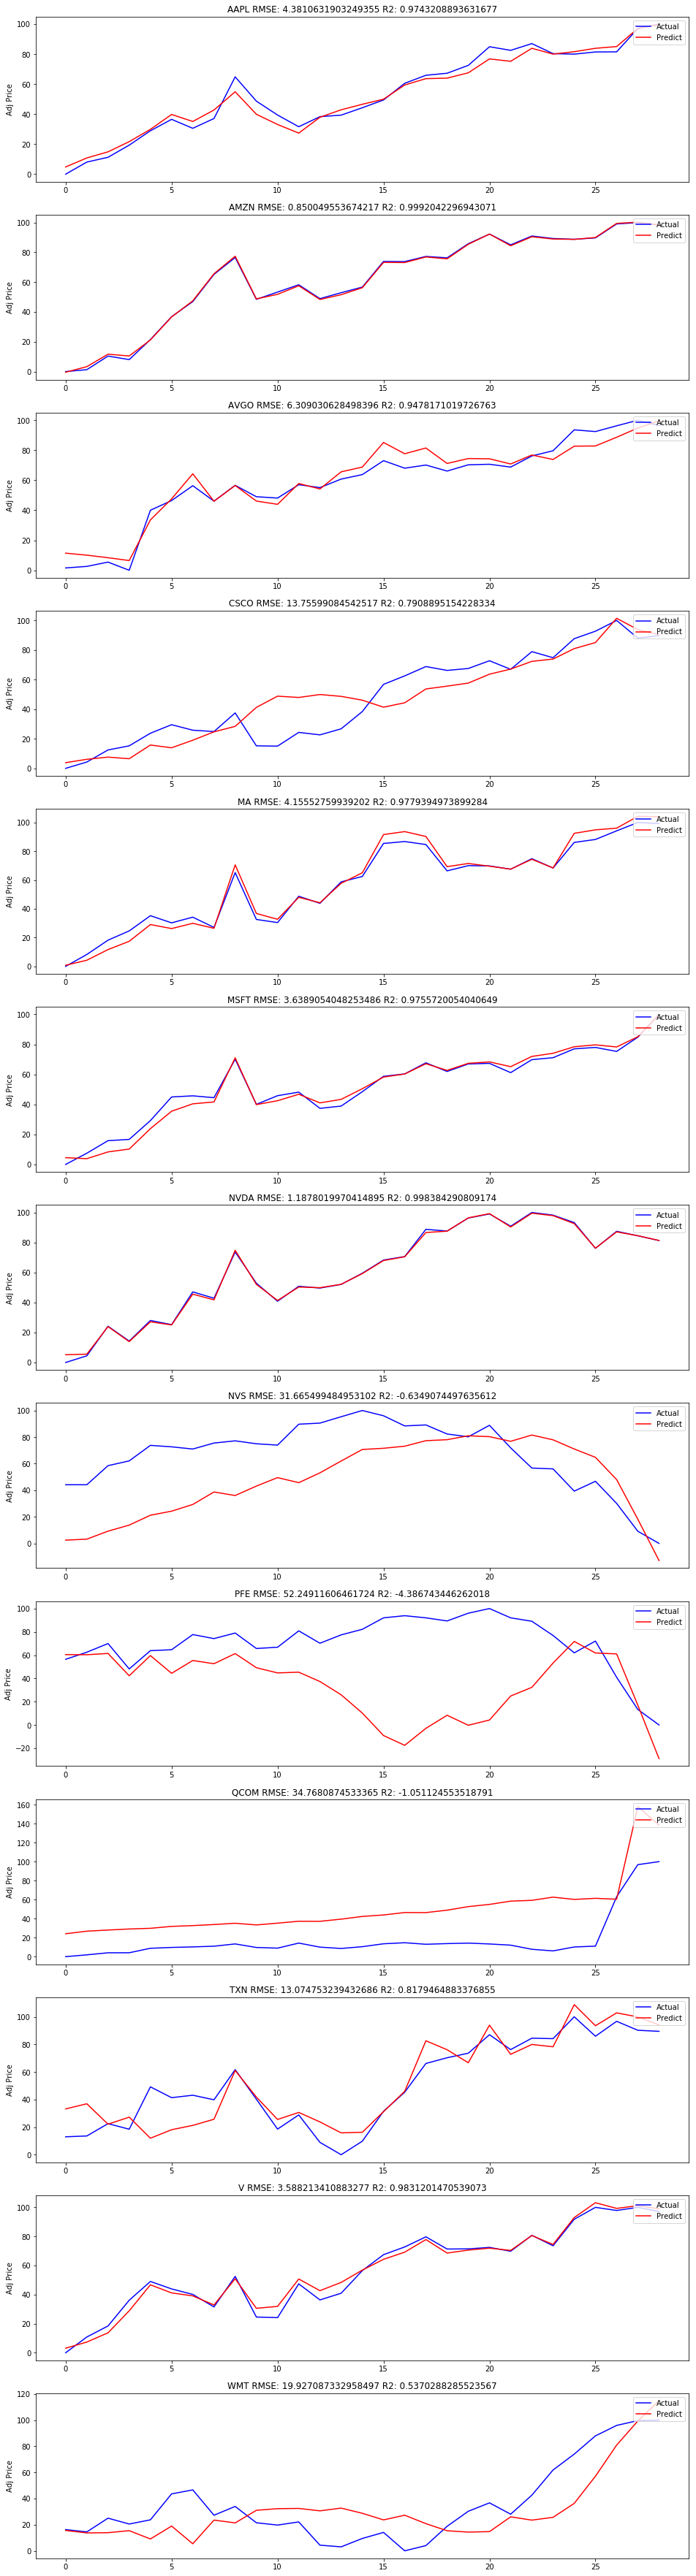

In [57]:
def get_title(index, rmse_list, r2_list):
    return stock_list[index] + " RMSE: " + str(rmse_list[index]) + " R2: " + str(r2_list[index])

def plot_prediction_vs_real(actual_array, predict_array):
    fig, axes = plt.subplots(nrows=13, ncols=1, figsize=(16, 64))
    for i, actual in enumerate(actual_array):
        axes[i].plot(actual_array[i].index, actual_array[i],'b', label='Actual')
        axes[i].plot(actual_array[i].index, predict_array[i],'r', label='Predict')
        axes[i].set_ylabel('Adj Price')
        axes[i].legend(loc='upper right')
        axes[i].set_title(get_title(i,rmse_list, r2_list))
    plt.show()
plot_prediction_vs_real(new_y_adj_close_list, y_predict_list)





